In [2]:
from pyvis.network import Network
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import geopandas as gpd

In [3]:
network = {}

In [4]:
with open("../datasets/Railway.csv") as f:

    prev_train = None
    prev_station = None

    for line in f:
        train, st_no, st_id, date, arr_time, dep_time, stay_time, mileage, lat, lon = line.split(",")
        lat = float(lat)
        lon = float(lon)

        if train != prev_train:
            prev_station = None
            network[train] = []

        station = {
            "id": int(st_id),
            "name": f"Station {st_id}",
            "lat": lat,
            "lon": lon,
            "from": prev_station["lat"] if prev_station else None,
            "to": None,
        }

        network[train].append(station)

        if prev_station:
            prev_station["to"] = (lat, lon)

        prev_train = train
        prev_station = station

In [5]:
#create hashtable of station id and (lat,long) as key
station_id = {}
for train in network:
    for station in network[train]:

        station_id[(station['lat'], station['lon'])] = station['id']

In [6]:
# create an empty graph
G = nx.Graph()

# add nodes to the graph
for stations in network:
    for station in network[stations]:
        # print(station)
        #add note with the localisation for visualization
        G.add_node(station['id'], pos=(station['lon'], station['lat']))


# add edges to the graph
for stations in network:
    for station in network[stations]:
        from_node = station['id']
        to_node = None

        if type(station['to']) is tuple:
            # if the 'to' value is a tuple, create a new node
            to_node = station_id[station['to']]
            G.add_edge(from_node, to_node)
        else:
            # # if the 'to' value is an existing node, add an edge
            # to_node = station['to']
            # G.add_edge(from_node, to_node)
            continue

# Graph Statistics

In [26]:
print("Graph Statistics:")
print("Clustering Coefficient: \t", nx.average_clustering(G))
print("Average Shortest Path Length: \t", nx.average_shortest_path_length(G))
print("Diameter: \t", nx.diameter(G))
print("Radius: \t", nx.radius(G))
print("Number of Nodes: \t", G.number_of_nodes())
print("Number of Edges: \t", G.number_of_edges())
print("Density: \t", nx.density(G))
print("Transitivity: \t", nx.transitivity(G))
print("Average Degree: \t", np.mean(list(dict(G.degree()).values())))
print("Average Clustering: \t", np.mean(list(nx.clustering(G).values())))
print("Average Eigenvector Centrality: \t", np.mean(list(nx.eigenvector_centrality(G).values())))
print("Average Betweenness Centrality: \t", np.mean(list(nx.betweenness_centrality(G).values())))
print("Average Closeness Centrality: \t", np.mean(list(nx.closeness_centrality(G).values())))
print("Average Degree Centrality: \t", np.mean(list(nx.degree_centrality(G).values())))
print("Average Page Rank: \t", np.mean(list(nx.pagerank(G).values())))
print("Average Harmonic Centrality: \t", np.mean(list(nx.harmonic_centrality(G).values())))
print("Average Load Centrality: \t", np.mean(list(nx.load_centrality(G).values())))

Graph Statistics:
Clustering Coefficient: 	 0.42282885981651164
Average Shortest Path Length: 	 8.786388321248479
Diameter: 	 47
Radius: 	 24
Number of Nodes: 	 2719
Number of Edges: 	 6175
Density: 	 0.0016711225424011825
Transitivity: 	 0.3216588861144284
Average Degree: 	 4.542111070246414
Average Clustering: 	 0.42282885981651236
Average Eigenvector Centrality: 	 0.00557924423431049
Average Betweenness Centrality: 	 0.0028658035779346577
Average Closeness Centrality: 	 0.1207731738230761
Average Degree Centrality: 	 0.001671122542401183
Average Page Rank: 	 0.0003677822728944465
Average Harmonic Centrality: 	 375.0662728697425
Average Load Centrality: 	 0.0028658035779346547


In [27]:
#tabulate degree centrality, closeness centrality, Betweenness Centrality, Eigenvector Centrality
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigen_centrality = nx.eigenvector_centrality(G)

#display the statistics in a table
stats = pd.DataFrame([degree_centrality, closeness_centrality, betweenness_centrality, eigen_centrality]).T
stats.columns = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']
#write to file
# stats.to_csv('stats.csv')

In [28]:
stats

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
692,0.004415,0.155181,0.022524,8.662295e-03
1351,0.003679,0.143794,0.016451,2.183319e-03
698,0.001104,0.125740,0.000000,2.516111e-04
944,0.002208,0.134828,0.001943,8.853901e-04
232,0.002943,0.125985,0.007017,2.492824e-04
...,...,...,...,...
2768,0.000736,0.090018,0.002940,3.234174e-08
2679,0.000736,0.082601,0.002206,2.466000e-09
2657,0.000736,0.076310,0.001471,1.880379e-10
2682,0.000736,0.070905,0.000736,1.433865e-11


# VISUALISATION

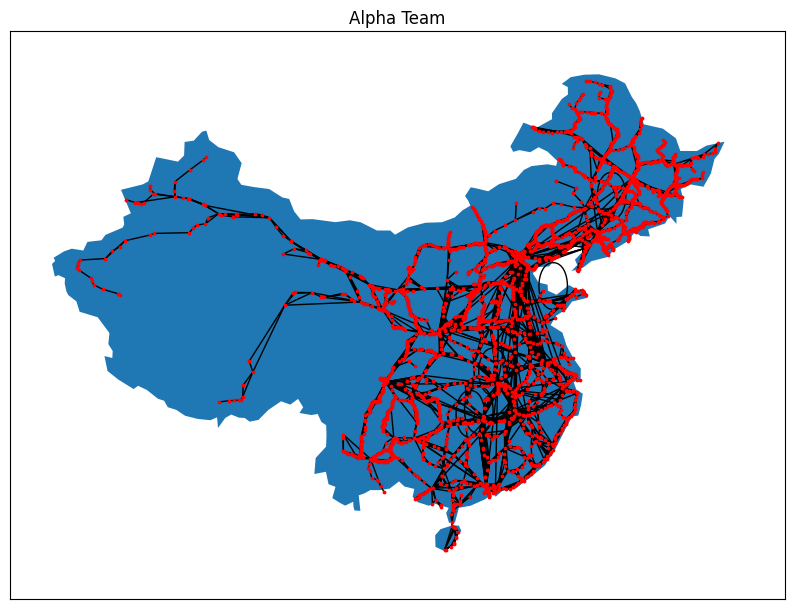

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

china=world[world['name'] == 'China']
china.plot(figsize=(10,10))

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G,pos, with_labels=False, node_size=3, node_color='red')

plt.axis('on')
plt.title("Alpha Team")

plt.show()

# DYNAMIC GRAPH

In [19]:
def remap(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [29]:
net = Network(notebook=True, height="1000px", width="100%", bgcolor='#222222', font_color="white", heading="China Railway Network")
net.from_nx(G)
for n in net.nodes:
    n.update({'physics': False,
              'x': remap(pos[n['id']][1], 15, 55, 0, 1000),
              'y': remap(pos[n['id']][0], 60, 140, 0, 2000),
              'size': 3,
              })

net.show_buttons(filter_=['configure','layout','interaction','physics','edges'])
net.show("railway_dynamic.html")

railway_dynamic.html


# SHORTEST PATH ANALYSIS

In [52]:
def shortest_path(G, source, target):
    return nx.shortest_path(G, source=source, target=target)

In [53]:
shortest_path(G, 1136, 1095)

[1136, 1763, 389, 390, 2058, 802, 1070, 2065, 1100, 2144, 1095]

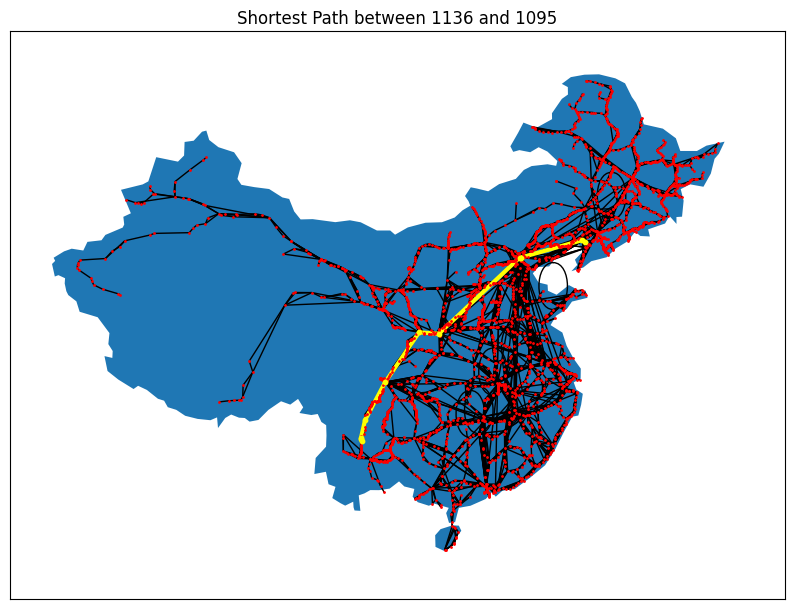

In [55]:
# Network Graph with the shortest path highlighted
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

china=world[world['name'] == 'China']
china.plot(figsize=(10,10))
import matplotlib.pyplot as plt
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=1, node_color='red')
shortest_path = nx.shortest_path(G, source=1095, target=1136)
nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_size=10, node_color='yellow')
nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path, shortest_path[1:])), edge_color='yellow', width=3)
plt.axis('on')
plt.title("Shortest Path between 1136 and 1095")
plt.show()
